<h1 align="center" style="margin-top:10px">Lesson 5</h1>
<h2 align="center" style="margin-top:10px">I didn't come up with common topic.</h2>

## Churn problem

**Business objective**: to predict which customers will end the relationship with the business, i.e., which customers will churn.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
#sns.set_context('notebook') 
sns.set_style('ticks')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

In [ ]:
df = pd.read_csv('CustomerChurn.csv',index_col=[0],decimal=',')
df['Churn'] = (df['Censor']==0).astype(int)
df.head()

,Duration,Censor,Avg_Ret_Exp,Avg_Ret_Exp_SQ,Industry,Revenue,Employees,Total_Crossbuy,Total_Freq,Total_Freq_SQ,Churn
Customer,,,,,,,,,,,
1,500,0,89.61,8029.95,1,30.16,1240,6,16,256,1
2,730,1,49.89,2489.01,0,39.80,166,6,10,100,0
3,730,1,40.70,1656.49,0,54.93,1016,2,14,196,0
4,340,0,85.76,7354.78,0,45.83,122,2,15,225,1
5,730,1,31.90,1017.61,0,69.03,313,1,9,81,0


In [ ]:
response='Churn'
predictors=['Avg_Ret_Exp', 'Revenue', 'Employees', 'Total_Crossbuy', 'Total_Freq', 'Industry']
df = df[[response]+predictors] # discarding variables that we will not use

We split the data into training (80%) and test (20%) sets before proceeding. Note that we use stratify parameter to get the same ratio in target in train and test data.

In [ ]:
from sklearn.model_selection import train_test_split

index_train, index_test  = train_test_split(np.array(df.index), stratify=df[response], train_size=0.8, random_state=5)

train = df.loc[index_train,].copy()
test =  df.loc[index_test,:].copy()

y_train = train[response]
y_test = test[response]

X_train = train[predictors]
X_test = test[predictors]

### EDA

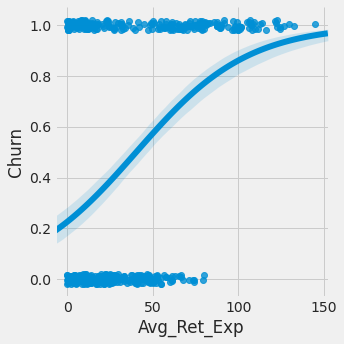

In [ ]:
plt.rcParams['figure.figsize'] = (10, 15)
sns.lmplot(data=df,x='Avg_Ret_Exp',y='Churn',y_jitter=.02,logistic=True, truncate=False)

It seems that starting at a certain amount it becomes pointless to spend money on retention.

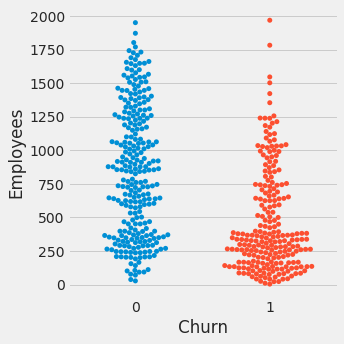

In [ ]:
plt.rcParams['figure.figsize'] = (10, 15)
sns.catplot(data=df,x='Churn',y='Employees',kind='swarm')

The risk that companies with small amount of employees will churn is higher.

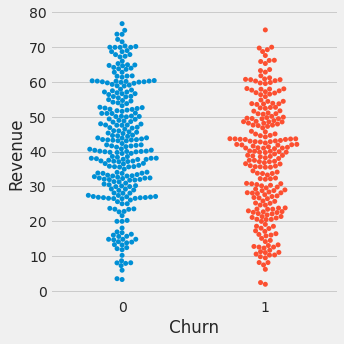

In [ ]:
plt.rcParams['figure.figsize'] = (10, 15)
sns.catplot(data=df,x='Churn',y='Revenue',kind='swarm')

## Lets create decision tree and random forest models

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model = DecisionTreeClassifier(criterion='entropy')

tuning_parameters = {
    'min_samples_leaf': [1,5,10,20,30,40,50],
     'max_depth': [2,4,5,6,8],
}

tree_search = GridSearchCV(model, tuning_parameters, cv= 5 , return_train_score=False)
tree_search.fit(X_train, y_train)

tree = tree_search.best_estimator_

In [ ]:
from sklearn.ensemble import  RandomForestClassifier

model = RandomForestClassifier(criterion = 'entropy')

tuning_parameters = {
    'n_estimators':[50,100,250,500,1000],
    'min_samples_leaf': [1, 5, 10, 20, 50],
    'max_features': np.arange(1, len(predictors)+1),
}

rf_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 50, return_train_score=False, n_jobs=4)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'n_estimators': 500, 'min_samples_leaf': 5, 'max_features': 2} 



In [ ]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=1e3)
logit.fit(X_train, y_train)

LogisticRegression(C=1000.0)

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
tree_scores = cross_validate(tree, X_train, y_train, cv=5, scoring=('precision','recall','f1'))

In [ ]:
print('Tree metrics')
print(f"precision: {np.round(tree_scores['test_precision'].mean(),3)}")
print(f"recall: {np.round(tree_scores['test_recall'].mean(),3)}")
print(f"f1: {np.round(tree_scores['test_f1'].mean(),3)}")

Tree metrics
precision: 0.797
recall: 0.774
f1: 0.784


In [ ]:
rf_scores = cross_validate(rf, X_train, y_train, cv=5, scoring=('precision','recall','f1'))
print('RF metrics')
print(f"precision: {np.round(rf_scores['test_precision'].mean(),3)}")
print(f"recall: {np.round(rf_scores['test_recall'].mean(),3)}")
print(f"f1: {np.round(rf_scores['test_f1'].mean(),3)}")

RF metrics
precision: 0.842
recall: 0.796
f1: 0.815


In [ ]:
logit_scores = cross_validate(logit, X_train, y_train, cv=5, scoring=('precision','recall','f1'))
print('LR metrics')
print(f"precision: {np.round(logit_scores['test_precision'].mean(),3)}")
print(f"recall: {np.round(logit_scores['test_recall'].mean(),3)}")
print(f"f1: {np.round(logit_scores['test_f1'].mean(),3)}")

LR metrics
precision: 0.82
recall: 0.796
f1: 0.804


## Tune LightGBM

Grid search is one Hyperparameters tuning algorithm where we try all possible combinations of hyperparameters. Trying all possible combinations of hyperparameters can take a lot of time (sometimes even days if there is a lot of data) even on powerful computers.

We need an algorithm that tries combinations that are giving good results only.

* Sampling Strategy - It uses a sampling algorithm for selecting the best hyperparameters combination from a list of all possible combinations. It concentrates on areas where hyperparameters are giving good results and ignores others resulting in time savings.
* Pruning Strategy - It uses a pruning strategy that constantly checks for algorithm performance during training and prunes (terminates) training for particular hyperparameters combination if it's not giving good results. This also results in time-saving. 

In [ ]:
!pip install optuna --q

     |████████████████████████████████| 348 kB 5.2 MB/s 
     |████████████████████████████████| 81 kB 8.3 MB/s 
     |████████████████████████████████| 209 kB 62.4 MB/s 
     |████████████████████████████████| 78 kB 6.9 MB/s 
     |████████████████████████████████| 50 kB 5.1 MB/s 
     |████████████████████████████████| 147 kB 64.5 MB/s 
     |████████████████████████████████| 112 kB 61.5 MB/s 


In [ ]:
import optuna
import lightgbm as lgb

Method 1. Use scikit-learn API

In [ ]:
def objective(trial): 
    
    random_state=42
    #X_train_lgb, X_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)
    #d_train = lgb.Dataset(X_train_lgb, label=y_train_lgb)
    #d_test = lgb.Dataset(X_valid_lgb, label=y_valid_lgb)

    param = {
        "verbosity": -1,
        "objective": "binary",
        "metric": "binary_logloss",
        "learning_rate":trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "feature_fraction":trial.suggest_float("feature_fraction", 0.5, 1.0, log=False),
        "n_estimators":trial.suggest_int("n_estimators", 50, 1000),
        "min_data_in_leaf":trial.suggest_int("max_depth", 1, 50),
    }

    model=lgb.LGBMClassifier(**param)
    score = cross_validate(model, X_train, y_train, cv=5, scoring=('f1'))
    score = score['test_score'].mean()
    return score

In [ ]:
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-06 20:20:40,006] A new study created in memory with name: no-name-d6a5b381-f564-4b2c-9d94-16dc8b2704c8
[I 2022-12-06 20:20:40,762] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 4.160359492725165e-08, 'max_depth': 29, 'feature_fraction': 0.9196708692324889, 'n_estimators': 803}. Best is trial 0 with value: 0.0.
[I 2022-12-06 20:20:41,262] Trial 1 finished with value: 0.830056551635499 and parameters: {'learning_rate': 0.02987754807801437, 'max_depth': 27, 'feature_fraction': 0.5229591010045764, 'n_estimators': 481}. Best is trial 1 with value: 0.830056551635499.
[I 2022-12-06 20:20:42,409] Trial 2 finished with value: 0.5731649733913885 and parameters: {'learning_rate': 0.0003624683310108241, 'max_depth': 10, 'feature_fraction': 0.597260142903389, 'n_estimators': 533}. Best is trial 1 with value: 0.830056551635499.
[I 2022-12-06 20:20:43,352] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 8.204537338011612e-06, 'max_depth': 9, 'feature

Number of finished trials:  100
Best trial:
  Value: 0.86861266227502
  Params: 
    learning_rate: 0.02217286387624977
    max_depth: 8
    feature_fraction: 0.9540841496537155
    n_estimators: 837


Method 2. Use integration

In [ ]:
import optuna.integration.lightgbm as lgb_tuner

params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",                
        "seed": 42
    }

random_state=42
X_train_lgb, X_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)
d_train = lgb.Dataset(X_train_lgb, label=y_train_lgb)
d_test = lgb.Dataset(X_valid_lgb, label=y_valid_lgb)


booster = lgb_tuner.train(params, d_train, valid_sets=d_test,
                    verbose_eval=-1,
                    show_progress_bar=True
                         )

[I 2022-12-04 19:54:12,146] A new study created in memory with name: no-name-96b81460-0618-4ac1-a146-8eb4d7eeff15
min_data_in_leaf, val_score: 0.347993: 100%|##########| 5/5 [00:00<00:00,  9.76it/s]


In [ ]:
params = booster.params
score = cross_validate(lgb.LGBMClassifier(**params), X_train, y_train, cv=5, scoring=('f1'))
score['test_score'].mean()

In [ ]:
score['test_score'].mean()

0.829092410635256

In [ ]:
lgb_model = lgb.LGBMClassifier(**study.best_trial.params)
lgb_scores = cross_validate(lgb_model, X_train, y_train, cv=5, scoring=('precision','recall','f1'))
print('LR metrics')
print(f"precision: {np.round(lgb_scores['test_precision'].mean(),3)}")
print(f"recall: {np.round(lgb_scores['test_recall'].mean(),3)}")
print(f"f1: {np.round(lgb_scores['test_f1'].mean(),3)}")

LR metrics
precision: 0.872
recall: 0.828
f1: 0.848


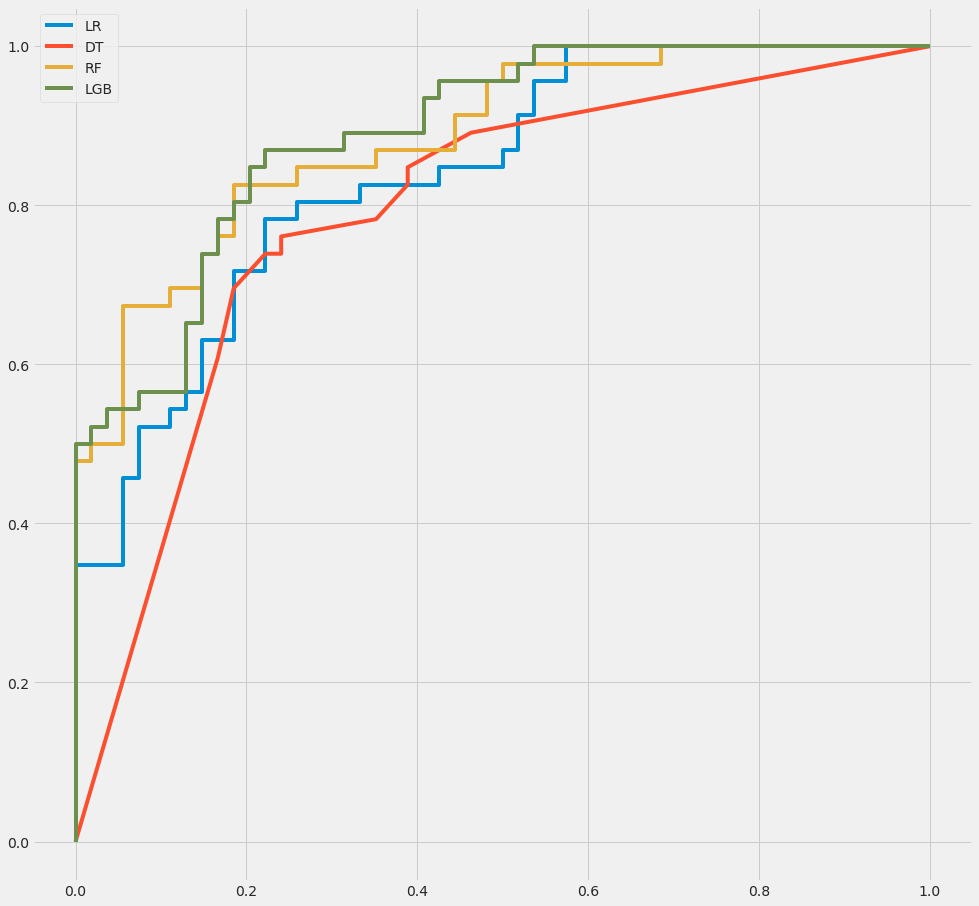

In [ ]:
from sklearn.metrics import roc_curve
y_prob = logit.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
plt.plot(fpr, tpr, label='LR')

y_prob = tree.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
plt.plot(fpr, tpr, label='DT')


y_prob = rf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
plt.plot(fpr, tpr, label='RF')

#lgb_model = lgb.LGBMClassifier(**study.best_trial.params)
lgb_model = lgb.LGBMClassifier(**params)
lgb_model = lgb_model.fit(X_train,y_train)
y_prob = lgb_model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
plt.plot(fpr, tpr, label='LGB')

plt.legend(loc="upper left")
plt.rcParams['figure.figsize'] = (15, 15)


plt.show()

Important

* RF and LGB overfitted
* On a small sample, cross-validation did not help
* We should separately consider observations for which a random forest works better than a boosting

We can see that the solution is not sustainable. The F-score varies from 0.84 to 0.86

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_contour(study, params=["max_depth", "learning_rate"])

In [ ]:
optuna.visualization.plot_contour(study, params=["max_depth", "feature_fraction"])

Optuna is a software framework for automating the optimization process of these hyperparameters. It automatically searches for and finds optimal hyperparameter values by trial and error for excellent performance. 
Optuna uses a history record of trials to determine which hyperparameter values to try next. Using this data, it estimates a promising area and tries values in that area. Optuna then estimates an even more promising region based on the new result. It repeats this process using the history data of trials completed thus far. Specifically, it employs a Bayesian optimization algorithm called Tree-structured Parzen Estimator.

[How to use in Python](https://coderzcolumn.com/tutorials/machine-learning/simple-guide-to-optuna-for-hyperparameters-optimization-tuning)

[How it work](https://distill.pub/2020/bayesian-optimization/)

что считать черном

## What is churn?

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/churn.png?raw=true:, width=800" alt="My Image" width=800>

In a machine learning task, we work with churn as a fact: was or was not. The naive approach is the percentage of users we lost over a period of time. As a rule, a cohort approach is used for detailed analysis. 

** Ways to calculate churn: **

1. Percentage of current customers who canceled in a given day/week/month. The outbursts will mean that you probably had some kind of disaster. For example,the servers went out of order or you unluckily raised prices.
2. Percentage of new customers in a given month which end up canceling at
any later date. This is o!en called “cohort analysis“. This is especially
useful if — like most companies — you have a higher cancellation rate with
new customers than with old ones, and you (think you) have taken steps to
improve that situation, and want to measure that progress.
3. Absolute number of cancellations per week. This metric is supposed to
increase over time at a growing SaaS company simply because there are more
and more customers available to cancel.
4. Percentage of all customers who’ve cancelled over the lifetime of the
company to-date. This is another way of measuring an “in/out” ratio —
plotting relative number of new customers arriving versus customers exiting.
5. Cancellation rate by age. You take the number of cancellations in a given time period (we use months), broken out by age (e.g. younger than 30 days old versus older), and then compute the “cancellation rate” as a percentage of all customers in that age group who cancelled. Like many companies, we’ve found that people who cancel soon a!er sign-up do so for very di$erent reasons than those who cancel a!er a year, and we care about those two groups differently, and we act on them differently.

Cohort analysis also lets you understand which factors lead to high
engagement and customer retention. If you focus on retention and
providing value to existing customers, you’ll often get a higher ROI
than if you focus purely on customer acquisition. You’ve already
invested time, money, and effort into acquiring customers, so it
makes sense to try and keep them on your platform instead of only
focusing on reaching new users.

Start your analysis by grouping users based on when they joined your app. “Date joined” is a type of acquisition cohort—you’ll use behavioral cohorts later in your analysis. Rather than looking at churn rates across all users, this will let you see when users churn in relation to the customer lifecycle.

Create daily, weekly, or monthly cohorts, depending on your type of
app and your product usage interval. For example, if you run a
meditation or fitness app, it’ll be useful to look at daily acquisition
and usage. If it’s an app people might use less frequently (like an
investing app), you’ll probably use monthly or weekly cohorts.

Take a look at your cohort analysis chart and find points when many
users churn. To visualize the retention curve and easily spot when
people drop off, convert your cohort table into a chart.

After you’ve looked at churn in relation to the acquisition date,
creating groups of users based on their behaviors, acquisition
channels, or demographics will help you understand them further. It
brings you one step closer to discovering the reasons why users
leave.

Use behavioral cohorts to group users by actions they have or
haven’t taken. You might look at users who read reviews before
purchasing or those who make an in-app purchase within the first
three days of joining the platform. In each case, you’ll want to
compare the cohort who does take the action with those who don’t to
see if there are any links to churn.

In addition to using behavioral cohorts, group users by type of
acquisition to identify which channels lead to churn and when. For
example, you might notice that users from paid ads churn faster
than those who convert from your newsletter. Another way of
segmenting users is by demographics—look for patterns among
different age groups or locations.

For consistency, look at different cohort types in the same time
frame as the acquisition cohort analysis you did. Investigate one
customer cohort at a time, so you can clearly see which factors are
contributing to churn. You’ll start to draw conclusions about why
cohorts vary in the next step.

**Hypothesize why churn happened for each cohort**

**For example, from the acquisition date cohorts:**
* Seasonal changes impact app usage—a lot of users joined
during the holidays, but they churn in February because
they don’t have enough free time to use the app. 
* Users drop off after two days because the onboarding process is too long and complicated.

**From the behavioral cohorts:**

* Users who sign up for the “basic” plan churn because they
don’t have access to enough features.
* Users who don’t activate reminder notifications end up
churning because they forget to use the app and don’t get
value from it.

**From the acquisition channel cohorts:**

* Users who sign up from the Instagram ad churn quickly
because the ad doesn’t accurately portray the product, so
there’s a discord between customer expectations and the
product.

In [ ]:
df = pd.read_csv('MRR_data.csv')
df.head()

,Userid,Month,First_month,MRR,Fav_func
0,1,01.01.2022,01.01.2022,100,Photo
1,1,01.02.2022,01.01.2022,100,Photo
2,1,01.03.2022,01.01.2022,100,Photo
3,1,01.04.2022,01.01.2022,100,Photo
4,1,01.05.2022,01.01.2022,100,Photo


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Userid       766 non-null    int64         
 1   Month        766 non-null    datetime64[ns]
 2   First_month  766 non-null    datetime64[ns]
 3   MRR          766 non-null    int64         
 4   Fav_func     766 non-null    object        
 5   Month_N      766 non-null    int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 36.0+ KB


In [ ]:
df['Month'] = pd.to_datetime(df['Month'],dayfirst=True)
df['First_month'] = pd.to_datetime(df['First_month'],dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Userid       766 non-null    int64         
 1   Month        766 non-null    datetime64[ns]
 2   First_month  766 non-null    datetime64[ns]
 3   MRR          766 non-null    int64         
 4   Fav_func     766 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 30.0+ KB


In [ ]:
df['Month_N'] = df['Month'].map(lambda x: x.month) - df['First_month'].map(lambda x: x.month)

In [ ]:
df_users_fm = df[['First_month','Userid']].groupby(['First_month']).nunique().reset_index().rename(columns={"Userid": "Users_fm"})

In [ ]:
df_users_by_month = df[['First_month','Month_N','Userid']].groupby(['First_month','Month_N']).nunique().reset_index().rename(columns={"Userid": "Users_month"})

In [ ]:
df_retention = pd.merge(df_users_by_month,df_users_fm,how='left',on='First_month')

In [ ]:
df_retention['retention'] = np.round(df_retention['Users_month']/df_retention['Users_fm'],2)

In [ ]:
df_retention

,First_month,Month_N,Users_month,Users_fm,retention
0,2022-01-01,0,39,39,1.00
1,2022-01-01,1,21,39,0.54
2,2022-01-01,2,21,39,0.54
3,2022-01-01,3,20,39,0.51
4,2022-01-01,4,20,39,0.51
...,...,...,...,...,...
58,2022-07-01,1,16,32,0.50
59,2022-07-01,2,15,32,0.47
60,2022-07-01,3,9,32,0.28
61,2022-07-01,4,8,32,0.25


In [ ]:
df_retention['First_month'] = df_retention['First_month'].dt.date

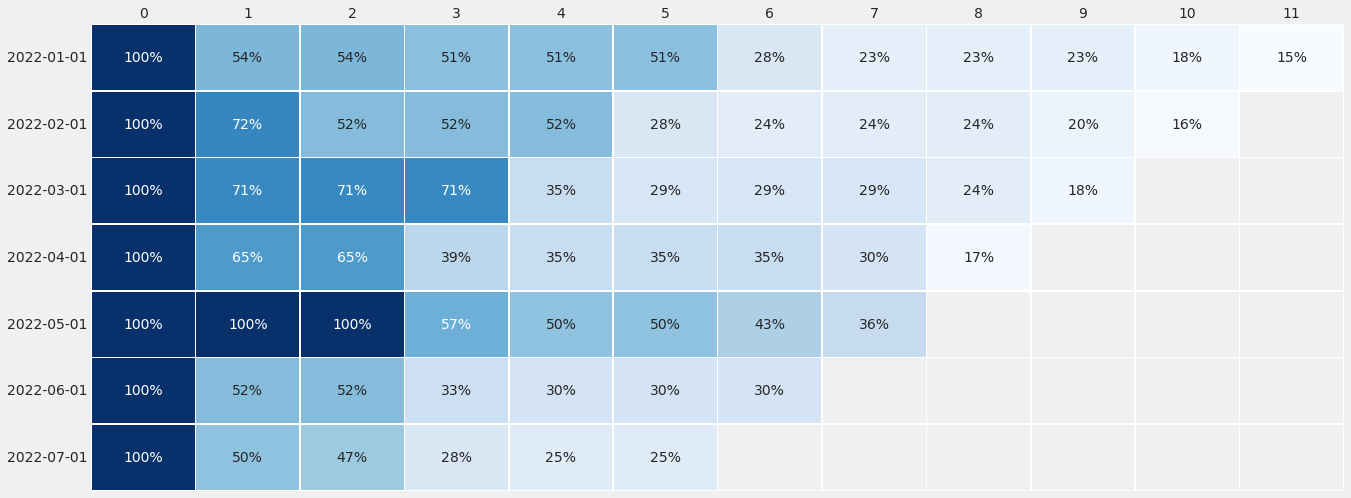

In [ ]:
df_pivot = df_retention.pivot("First_month", "Month_N", "retention")
plt.rcParams['figure.figsize'] = (20,8)
ax = sns.heatmap(df_pivot,annot=True,fmt='.0%',cbar=False,linewidth=.5,cmap = "Blues")
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

## LTV

We again focus on the customer acquisition and profitability dataset

The objective of this type of analysis is to predict the profitability of a customer, which involves both classification and regression tasks. We apply classification methods to predict whether a customer will be acquired and retained, and we apply regression methods to estimate the profitability of acquired and retained customers to the company.
Here, we focus on the latter task (regression), though a more complete model can include all parts of the customer cycle. In particular, we will model the customer lifetime value (CLV) taking into account nonlinearities present in the data.
The response variable, thus, is the customer lifetime value (CLV, a measure of profitability) of customers who were acquired and remained as customers by the end of the observation window (730 days). These customers are identified with a value of one for the Censor variable.

## Infra

<img src="https://github.com/mashinistt/pics_for_collab/blob/main/infra.png?raw=true:, width=800" alt="My Image" width=800>